### 清理數據


In [12]:
import shutil

# 刪除目錄前先確認目錄存在
for d in [train_dir, validation_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)  # 完全刪除該目錄及其所有內容


### 確認圖片類型&數量

In [5]:
import os

# 設置圖片資料夾的路徑
base_path = r'C:\Users\coding\Desktop\trashnet\trashnet\dataset-resized\dataset-resized'

# 初始化一個字典來存儲每個類別的圖片數量
category_counts = {}

# 遍歷資料夾中的每個子資料夾
for category in os.listdir(base_path):
    category_path = os.path.join(base_path, category)
    
    # 確保這是一個目錄
    if os.path.isdir(category_path):
        # 計算該類別目錄中的圖片數量
        category_counts[category] = len([name for name in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, name))])

# 打印出每個類別的圖片數量
for category, count in category_counts.items():
    print(f'Category: {category}, Image Count: {count}')


Category: cardboard, Image Count: 403
Category: glass, Image Count: 501
Category: metal, Image Count: 410
Category: paper, Image Count: 594
Category: plastic, Image Count: 482
Category: trash, Image Count: 137


### 隨機顯示圖片

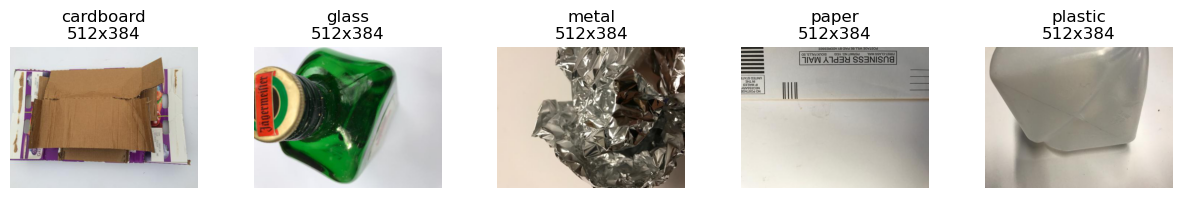

In [4]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Set the base path to your dataset
base_path = r'C:\Users\coding\Desktop\trashnet\trashnet\dataset-resized\dataset-resized'

# Exclude the 'trash' category
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

# Create subplots to display images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for ax, category in zip(axes.flat, categories):
    category_path = os.path.join(base_path, category)
    # Randomly select an image
    random_image_name = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, random_image_name)
    image = Image.open(image_path)
    
    # Display the image and its dimensions
    ax.imshow(image)
    ax.set_title(f'{category}\n{image.size[0]}x{image.size[1]}')
    ax.axis('off')

plt.show()


### 引用接下來需要的套件

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### 建立train&test&validation資料夾目錄

In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 指定原始數據集路徑
base_dir = 'C:/Users/coding/Desktop/trashnet/trashnet/dataset-resized/dataset-resized'
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

# 為訓練、測試和驗證數據創建目錄
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, validation_dir, test_dir]:
    if not os.path.exists(d):
        os.mkdir(d)
    for category in categories:
        category_dir = os.path.join(d, category)
        if not os.path.exists(category_dir):
            os.mkdir(category_dir)


### 在空目錄中分配圖片，修正這裡的參數可以調整train&test&vali的比例

In [15]:
# 設置分割比例
train_size = 0.7
validation_size = 0.15
test_size = 0.15

for category in categories:
    # 獲取每個類別的所有圖片
    source_dir = os.path.join(base_dir, category)
    all_files = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # 分割數據
    train_files, test_files = train_test_split(all_files, test_size=test_size + validation_size, random_state=42)
    validation_files, test_files = train_test_split(test_files, test_size=test_size/(test_size + validation_size), random_state=42)

    # 定義一個函數來將文件復制到相應的目錄
    def copy_files(files, destination_dir):
        for f in files:
            shutil.copy(f, destination_dir)

    # 復制文件到相應的目錄
    copy_files(train_files, os.path.join(train_dir, category))
    copy_files(validation_files, os.path.join(validation_dir, category))
    copy_files(test_files, os.path.join(test_dir, category))


### 顯示分配後的個目錄的圖片數量

In [16]:
# 函數：計算指定目錄下每類圖片的數量
def count_images(dir_path, categories):
    counts = {}
    for category in categories:
        category_path = os.path.join(dir_path, category)
        # 計算每個目錄中的文件數（假設每個文件都是一張圖片）
        counts[category] = len([name for name in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, name))])
    return counts

# 計算並顯示每個數據集中每個類別的圖片數量
train_counts = count_images(train_dir, categories)
validation_counts = count_images(validation_dir, categories)
test_counts = count_images(test_dir, categories)

# 顯示結果
print("Train Counts:", train_counts)
print("Validation Counts:", validation_counts)
print("Test Counts:", test_counts)

Train Counts: {'cardboard': 282, 'glass': 350, 'metal': 287, 'paper': 415, 'plastic': 337}
Validation Counts: {'cardboard': 60, 'glass': 75, 'metal': 61, 'paper': 89, 'plastic': 72}
Test Counts: {'cardboard': 61, 'glass': 76, 'metal': 62, 'paper': 90, 'plastic': 73}


### 利用tensorflow進行一些進一步的圖片處理

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 基礎路徑
base_dir = 'C:/Users/coding/Desktop/trashnet/trashnet/dataset-resized/dataset-resized'

# 設定 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# 生成器
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),  # 根據模型需求調整
    batch_size=20,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')


Found 1671 images belonging to 5 classes.
Found 357 images belonging to 5 classes.


### 設定模型結構&建立模型

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

### 訓練並顯示模型表現

Epoch 1/30
83/83 [==============================] - 32s 384ms/step - loss: 1.4956 - accuracy: 0.3440 - val_loss: 1.4167 - val_accuracy: 0.3500
Epoch 2/30
83/83 [==============================] - 30s 361ms/step - loss: 1.3489 - accuracy: 0.4113 - val_loss: 1.2850 - val_accuracy: 0.4618
Epoch 3/30
83/83 [==============================] - 31s 370ms/step - loss: 1.2947 - accuracy: 0.4373 - val_loss: 1.2295 - val_accuracy: 0.4412
Epoch 4/30
83/83 [==============================] - 31s 375ms/step - loss: 1.2198 - accuracy: 0.4985 - val_loss: 1.2835 - val_accuracy: 0.4882
Epoch 5/30
83/83 [==============================] - 32s 389ms/step - loss: 1.2002 - accuracy: 0.5100 - val_loss: 1.1562 - val_accuracy: 0.5353
Epoch 6/30
83/83 [==============================] - 31s 366ms/step - loss: 1.1366 - accuracy: 0.5360 - val_loss: 1.2019 - val_accuracy: 0.5147
Epoch 7/30
83/83 [==============================] - 31s 367ms/step - loss: 1.1136 - accuracy: 0.5433 - val_loss: 1.0677 - val_accuracy: 0.5824

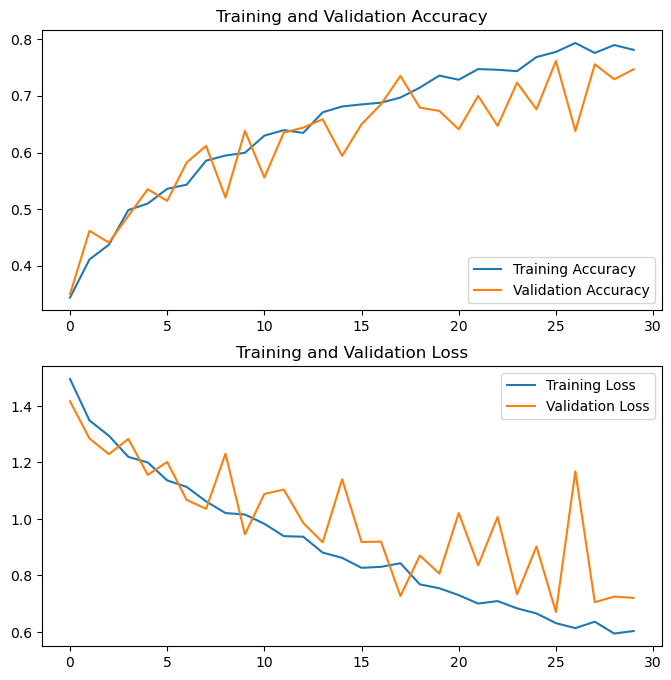

In [22]:
train_steps = len(train_generator.filenames) // train_generator.batch_size
val_steps = len(validation_generator.filenames) // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # 更新這裡
    epochs=30,
    validation_data=validation_generator,
    validation_steps=val_steps)  # 更新這裡


# 繪製訓練和驗證的準確度及損失圖
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### 儲存模型

In [23]:
model.save('proccedd_img_model.h5')  # 使用 HDF5 格式保存模型


c:\Users\coding\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 再次檢驗模型

In [24]:
from tensorflow.keras.models import load_model


# 加載之前保存的模型
model = load_model('proccedd_img_model.h5')

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 基礎路徑
base_dir = 'C:/Users/coding/Desktop/trashnet/trashnet/dataset-resized/dataset-resized'

# 數據預處理
datagen = ImageDataGenerator(rescale=1./255)

# 加載訓練、驗證和測試數據
train_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=False)

validation_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=False)

test_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=False)

# 評估模型
train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

# 打印結果
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Found 1671 images belonging to 5 classes.
Found 357 images belonging to 5 classes.
Found 362 images belonging to 5 classes.
19/19 [==============================] - 2s 105ms/step - loss: 0.8508 - accuracy: 0.6823
Training Loss: 0.37303584814071655, Training Accuracy: 0.8647516369819641
Validation Loss: 0.7155008316040039, Validation Accuracy: 0.7478991746902466
Test Loss: 0.8508327603340149, Test Accuracy: 0.6823204159736633


### 展示

1/1 [==============================] - 0s 108ms/step


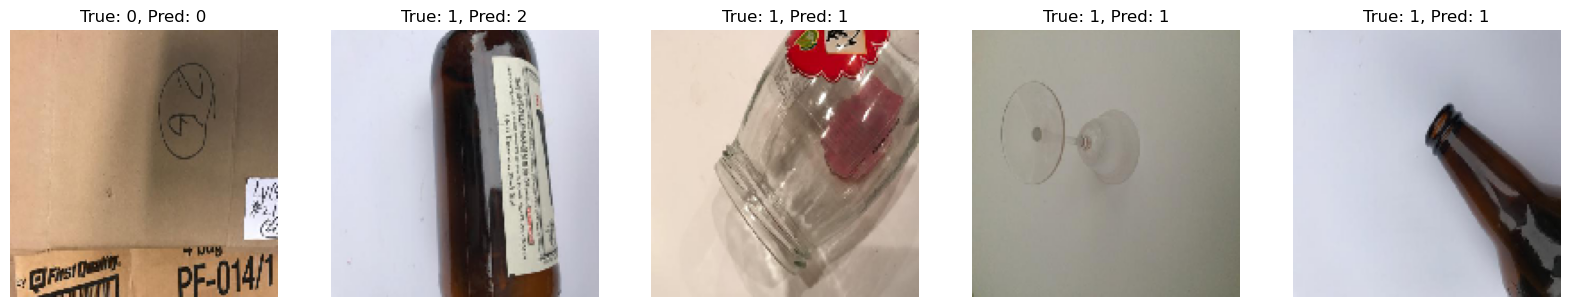

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 從測試數據生成器中取出一批圖像
for images, labels in test_generator:
    # 只取一批
    break

# 進行預測
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# 顯示圖像和預測結果
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
    ax.axis('off')
plt.show()
